<a href="https://colab.research.google.com/github/usmanaminch/stock-price-classifier/blob/main/Stock_Price_Classifier_Upgraded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages (if running locally)
# !pip install yfinance scikit-learn matplotlib pandas seaborn joblib

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set()


# 📈 Stock Price Direction Classifier — Upgraded Version
A machine learning model to predict whether the next day's market return will be positive or negative. Includes momentum indicators, baseline comparisons, and backtest with Sharpe Ratio.

## 🧩 Step 1: Load Market Data

In [2]:
ticker = 'SPY'
data = yf.download(ticker, start='2018-01-01', end='2024-12-31')

price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
data['Return'] = data[price_col].pct_change()
data['Direction'] = np.where(data['Return'] > 0, 1, 0)
data.dropna(inplace=True)
data.head()

/tmp/ipython-input-2-955893829.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2018-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Return,Direction
Ticker,SPY,SPY,SPY,SPY,SPY,,
Date,,,,,,,
2018-01-03,240.077667,240.228576,238.737335,238.737335,90070400,0.006325,1
2018-01-04,241.089584,241.577798,240.139839,240.725679,80636400,0.004215,1
2018-01-05,242.696182,242.820437,241.391363,241.888434,83524000,0.006664,1
2018-01-08,243.140106,243.299873,242.305730,242.598637,57319200,0.001829,1
2018-01-09,243.690369,244.320579,243.282039,243.566087,57254000,0.002263,1


## 🔧 Step 2: Feature Engineering

In [3]:
data['SMA_5'] = data[price_col].rolling(5).mean()
data['SMA_10'] = data[price_col].rolling(10).mean()
data['Volatility'] = data['Return'].rolling(10).std()
data['Momentum_5'] = data[price_col].pct_change(5)
data.dropna(inplace=True)

features = ['SMA_5', 'SMA_10', 'Volatility', 'Momentum_5']
X = data[features]
y = data['Direction']

## 🤖 Step 3: Train Models

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_preds = log_reg.predict(X_test)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


## 📊 Step 4: Evaluate Performance

In [5]:
print("Logistic Regression Report:")
print(classification_report(y_test, log_preds))

print("Random Forest Report:")
print(classification_report(y_test, rf_preds))

# Baseline comparison: always predict UP
baseline_preds = np.ones_like(y_test)
baseline_acc = accuracy_score(y_test, baseline_preds)
rf_acc = accuracy_score(y_test, rf_preds)

print(f"Baseline Accuracy (always UP): {baseline_acc:.2f}")
print(f"Random Forest Accuracy: {rf_acc:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, rf_preds)
print("Confusion Matrix (RF):\n", conf_matrix)

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.51      0.67      0.58       145
           1       0.70      0.54      0.61       205

    accuracy                           0.59       350
   macro avg       0.60      0.61      0.59       350
weighted avg       0.62      0.59      0.60       350

Random Forest Report:
              precision    recall  f1-score   support

           0       0.47      0.81      0.60       145
           1       0.73      0.37      0.49       205

    accuracy                           0.55       350
   macro avg       0.60      0.59      0.54       350
weighted avg       0.62      0.55      0.53       350

Baseline Accuracy (always UP): 0.59
Random Forest Accuracy: 0.55
Confusion Matrix (RF):
 [[117  28]
 [130  75]]


## 📈 Step 5: Backtest Simple Strategy

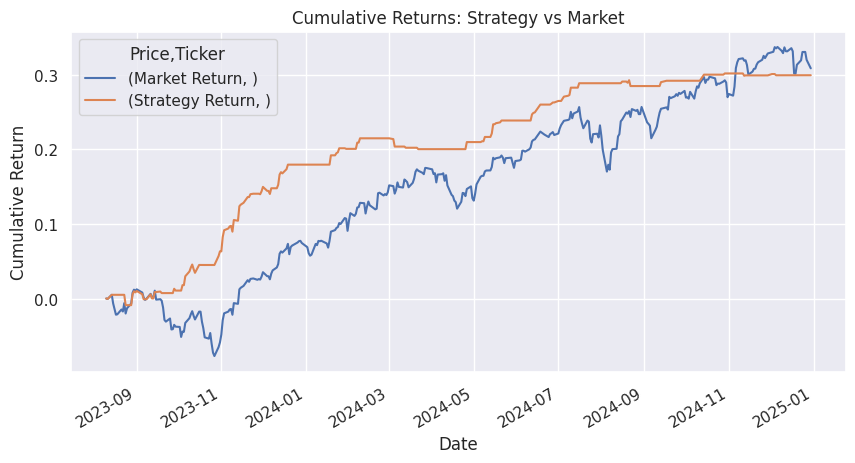

In [6]:
test_data = data.loc[X_test.index].copy()
test_data['Strategy'] = rf_preds
test_data['Market Return'] = test_data['Return']
test_data['Strategy Return'] = test_data['Market Return'] * test_data['Strategy']

test_data[['Market Return', 'Strategy Return']].cumsum().plot(figsize=(10, 5))
plt.title("Cumulative Returns: Strategy vs Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()

## 📐 Step 6: Sharpe Ratio

In [7]:
def sharpe_ratio(returns, risk_free_rate=0.00):
    excess_returns = returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns)

strategy_sr = sharpe_ratio(test_data['Strategy Return'])
market_sr = sharpe_ratio(test_data['Market Return'])

print(f"Strategy Sharpe Ratio: {strategy_sr:.2f}")
print(f"Market Sharpe Ratio: {market_sr:.2f}")

Strategy Sharpe Ratio: 0.25
Market Sharpe Ratio: 0.11


## 💾 Step 7: Save the Trained Model

In [8]:
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

## ✅ Next Steps
- Add more features (e.g., RSI, MACD, volume)
- Try other tickers or sectors
- Test more advanced models (XGBoost, LSTM)
- Publish to GitHub and write a short blog post
- Connect it to a real-time Streamlit dashboard!